![Static Badge](https://img.shields.io/badge/Data_Science-UdeA-green)
![Static Badge](https://img.shields.io/badge/Python-3.11.6-orange)

# Análisis exploratorio de los datos

## Universidad de Antioquia

### Especialización en Analítica y Ciencia de Datos

* Moisés Alfonso Guerrero Jiménez
* Andrés Castaño Licona

### Descripción Datos

Los datos usados hacen parte de un repositorio abierto con licencia Creative Commons Attribution, que contiene mediciones de radiación horizontal global solar (GHI), recopiladas durante un periodo de 18 años, desde el 1 de enero de 2002 hasta el 31 de diciembre de 2019, con una granularidad de 30 minutos, que fueron medidos en 37 estaciones ubicadas en la región española de Castilla y León.

El conjunto de datos no solo cuenta con datos crudos, sino también con datos refinados y etiquetados por estaciones de medición, contando además con variables meteorológicas y geográficas que complementan el valor de los datos de irradiación.

Los datos fueron publicados por integrantes del Departamento de Ingeniería Topográfica y Cartográfica de la Escuela Técnica Superior de Ingenieros en Topografía, Geodesia y Cartografía, Universidad Politécnica de Madrid, y se encuentran disponibles para su uso con fines de investigación en un repositorio público con nombre “CyL_GHI” disponible en el sitio web Zenodo (https://zenodo.org/records/7404167), y además cuentan con una documentación detallada con nombre “CyL-GHI: Global Horizontal Irradiance Dataset Containing 18 Years of Refined Data at 30-Min Granularity from 37 Stations Located in Castile and León (Spain)”, que describe de manera precisa mucho del preprocesamiento, estandarización y limpieza realizado por los autores, así como muchas de las características del dataset.

In [17]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import calendar

In [ ]:
# Descarga de datos por estaciones
!wget https://zenodo.org/records/7404167/files/CyL_by_stations.zip

# Descarga de los datos geográficos
!wget https://zenodo.org/records/7404167/files/CyL_geo.csv

Los archivos descargados incluyen un comprimido con todos los datos para las estaciones meteorológicas separados por un identificador único de cada estación en formato `csv` con nombre `CyL_by_stations.zip`, así como un archivo `csv` que incluye los datos geográficos de las estaciones meteorológicas con nombre `CyL_geo.csv`.

In [3]:
# Descomprimiendo archivo CyL_by_stations.zip

if platform.system() == 'Windows':
    os.popen("tar -xf CyL_by_stations.zip")
else:
    os.popen("unzip CyL_by_stations.zip")

#### Datos geográficos

In [4]:
# lectura del archivo de datos geográficos
df_geo = pd.read_csv("CyL_geo.csv", sep=",", header=0, index_col=0)
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_code  37 non-null     object 
 1   name          37 non-null     object 
 2   latitude      37 non-null     float64
 3   longitude     37 non-null     float64
 4   height        37 non-null     int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.7+ KB


Los datos geográficos incluyen código de estación, nombre de la estación meteorológica, latitud, longitud y altitud. No se presentan valores nulos teniendo un total de 37 registros correspondientes a cada una de las 37 meteorológicas relacionadas.

In [5]:
# Primeras 5 estaciones incluidas en el Dataframe
df_geo.head()

station_code                 name   latitude  longitude  height
0         AV01      Nava de Arévalo  40.968828  -4.767943     921
1         BU02  Valle de Valdelucio  42.746260  -4.132867     976
2         BU03                Lerma  42.039658  -3.768196     840
3         BU04             Tardajos  42.346138  -3.802584     822
4         BU05           Vadocondes  41.637103  -3.576803     811

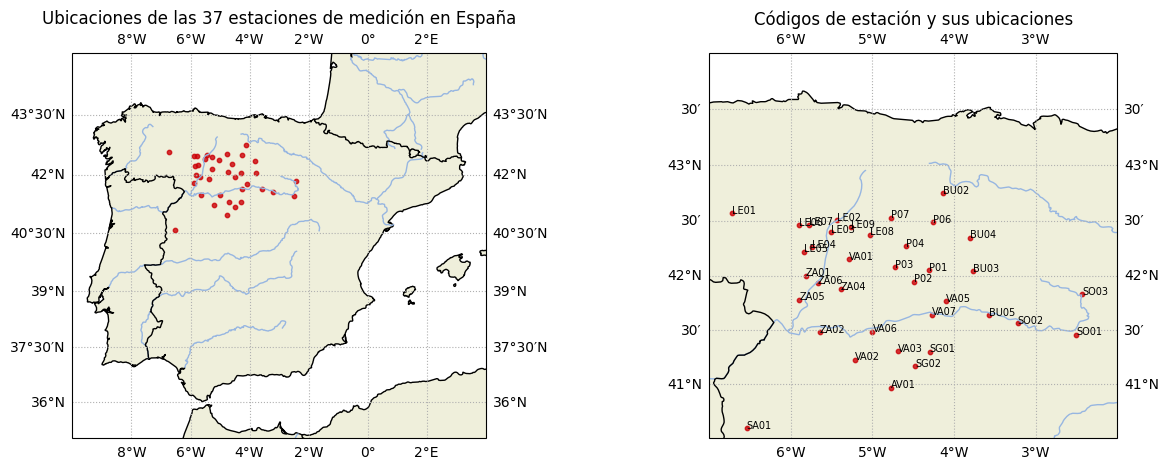

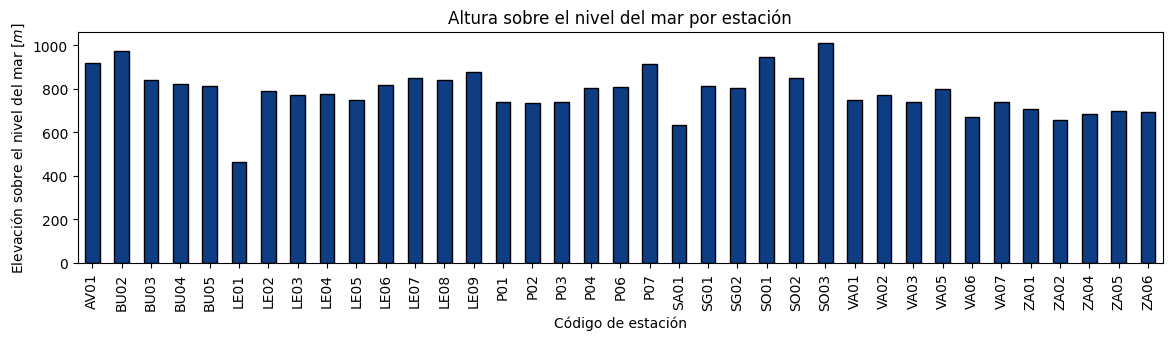

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.Mercator()})

ax[0].set_extent([-10, 4, 35, 45])
ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle=":");
ax[0].add_feature(cf.COASTLINE)
ax[0].add_feature(cf.LAND)
ax[0].add_feature(cf.RIVERS)
ax[0].add_feature(cf.BORDERS)

ax[0].scatter(df_geo['longitude'], df_geo['latitude'], marker='o', s=10, alpha=0.8, c='#CB0006', transform=ccrs.PlateCarree())
ax[0].set_title('Ubicaciones de las 37 estaciones de medición en España')

ax[1].set_extent([-7, -2, 40.5, 44])
ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle=":");
ax[1].add_feature(cf.COASTLINE)
ax[1].add_feature(cf.LAND)
ax[1].add_feature(cf.RIVERS)
ax[1].add_feature(cf.BORDERS)
ax[1].scatter(df_geo['longitude'], df_geo['latitude'], marker='o', s=10, alpha=0.8, c='#CB0006', transform=ccrs.PlateCarree())
ax[1].set_title('Códigos de estación y sus ubicaciones')

for index, row in df_geo.iterrows():
  ax[1].annotate(text=row['station_code'], xy=(row['longitude'], row['latitude']), fontsize=7, transform=ccrs.PlateCarree())

fig2, ax2 = plt.subplots(figsize=(14,3))
df_geo.plot(kind='bar', x='station_code', y='height', legend=False, edgecolor='k', color='#0E3D84', ax=ax2)
#ax2.grid(linestyle=":", axis='y')
ax2.set_xlabel("Código de estación")
ax2.set_ylabel("Elevación sobre el nivel del mar $[m]$")
ax2.set_title("Altura sobre el nivel del mar por estación")

plt.show()

#### Datos meteorológicos y de radiación solar

Se realiza la lectura inicial de los datos para solo una estación, con el fin de observar los datos medidos y su estructura en un Dataframe.

Los datos incluyen las siguiente columnas (las unidades fueron tomadas del sitio https://www.mdpi.com/2306-5729/8/4/65 que describe el conjunto de datos de forma detallada):

* **timestamp:** Corresponde a una marca de tiempo en el cual se tomaron las mediciones
* **GHI:** Global Horizontal Irradiance $(W/m^{2})$
* **toa:** Top of Atmosphere Radiation $(W/m^{2})$
* **wind_dir:** Dirección del viento en grados
* **humidity:** Humedad relativa medida en la estación en $%$
* **precipitation:** Precipitación en milímetros $(mm)$
* **air_temp:** Temperatura en grados celsius $(°C)$
* **wind_sp:** Velocidad del viento $(m/s)$
* **sun_elev:** Ángulo de elevación solar en grados
* **sun_azim:** Ángulo azimuth en grados

In [9]:
example_station = 'AV01'
year = 2008
print(f"Leyendo datos para la estación '{df_geo[df_geo.station_code == example_station]['name'].iloc[0]}' con código de estación '{example_station}'...\n")
df_example = pd.read_csv(f"CasyLeon_by_stations/{example_station}.csv", sep=',', header=0)
print(f"Filtrando datos para el año {year}...")
df_example = df_example[df_example.timestamp.between(f"{year}-01-01 00:00:00", f"{year}-12-31 11:59:59")]
df_example.describe()

Leyendo datos para la estación 'Nava de Arévalo' con código de estación 'AV01'...

Filtrando datos para el año 2008...


GHI           toa      wind_dir      humidity  precipitation  \
count  17127.000000  17544.000000  17002.000000  17002.000000   17002.000000   
mean     196.485493    325.314255    208.969820     72.307868       0.025767   
std      282.378529    408.537254     89.123697     22.883777       0.190632   
min        0.000000      0.000000      0.000000     11.260000       0.000000   
25%        0.000000      0.000000    167.717500     57.212500       0.000000   
50%       15.310000     19.615000    222.205000     79.675000       0.000000   
75%      342.780000    640.950000    275.557500     91.580000       0.000000   
max     1163.260000   1259.030000    359.990000     99.700000       8.160000   

           air_temp       wind_sp      sun_elev      sun_azim  
count  17002.000000  17002.000000  17544.000000  17544.000000  
mean      10.549719      2.495126      0.278600    179.312009  
std        8.088854      1.912342     35.647457    100.979620  
min       -7.010000      0.000000    -72.240000      0.000000  
25%        4.710000      1.130000    -27.422500     89.127500  
50%        9.390000      1.940000      0.305000    179.735000  
75%       15.357500      3.350000     27.980000    269.902500  
max       36.350000     13.610000     72.280000    360.000000

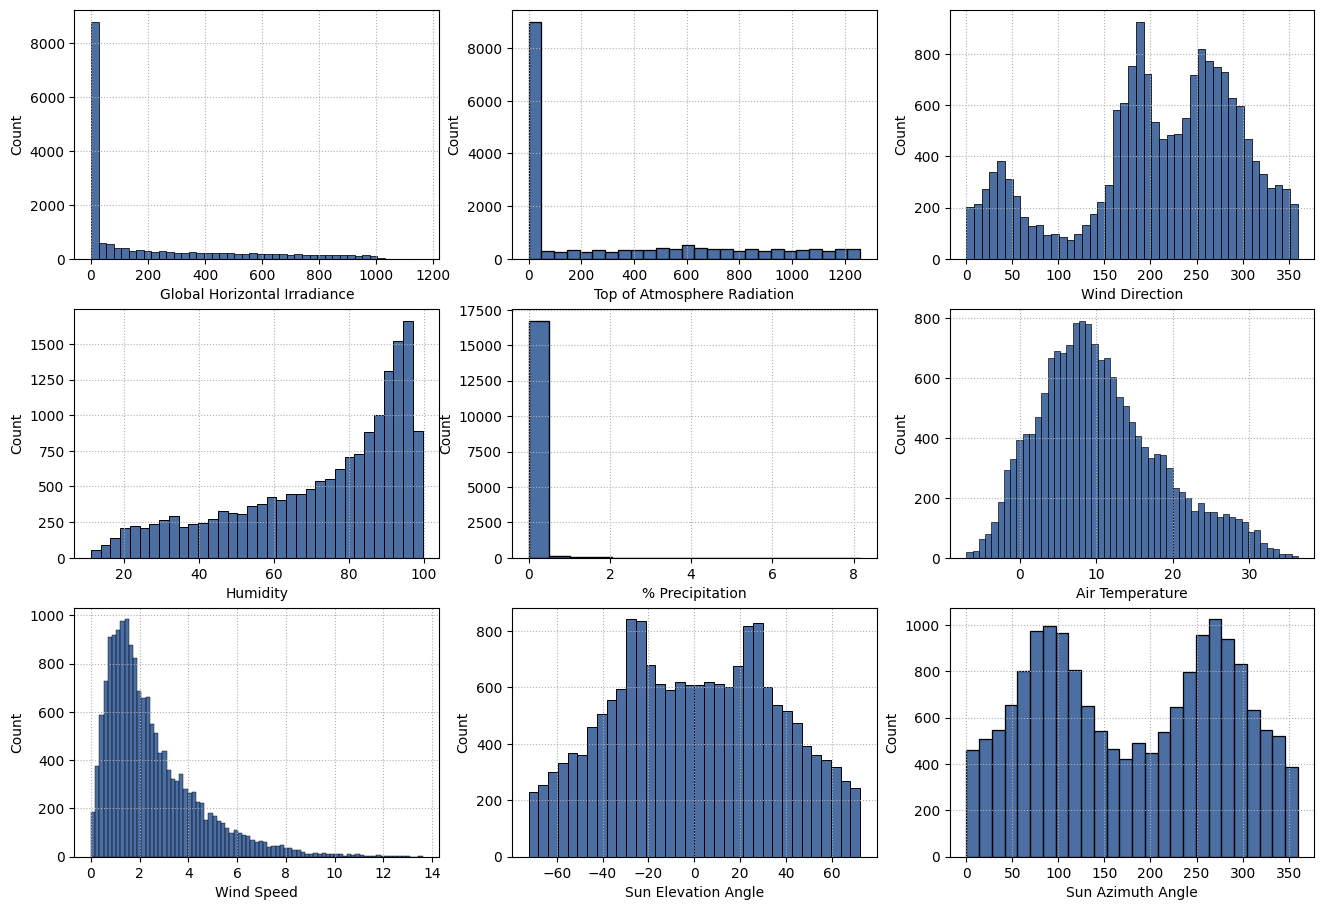

In [10]:
# Distribución de las variables numéricas
fig, ax = plt.subplots(3, 3, figsize=(16,11))
numVars = ['GHI', 'toa', 'wind_dir', 'humidity', 'precipitation',
       'air_temp', 'wind_sp', 'sun_elev', 'sun_azim']
names = ['Global Horizontal Irradiance', 'Top of Atmosphere Radiation', 'Wind Direction', 'Humidity', '% Precipitation',
        'Air Temperature', 'Wind Speed', 'Sun Elevation Angle', 'Sun Azimuth Angle']
for index, var in enumerate(numVars):
    sns.histplot(x = df_example[var], color='#0E3D84', ax=ax[index//3, index%3])
    ax[index//3, index%3].grid(linestyle=':')
    ax[index//3, index%3].set_xlabel(names[index])

- Los datos de radiación solar y radiación de atmósfera superior, TOA, mayormente presentan valores en cero, lo cual es esperado debido a los períodos nocturnos a lo largo del tiempo.
- La dirección del viento en grados muestra una alta variabilidad, con mayor frecuencia en tres ángulos cercanos a 40°, 190° y 260°.
- El porcentaje de humedad relativa presenta cierta variabilidad, con mayor frecuencia en un porcentaje cercano al 100%.
- El porcentaje de precipitaciones mayormente es bajo, cercano a cero.
- La temperatura del aire en promedio es cercana a 10.5°C, como se indica en la Tabla \ref{table:statisticsvars}, con una temperatura mínima de aproximadamente -7°C y una máxima de más de 36°C.
- La velocidad del viento mayormente se encuentra cercana a los 2.5 m/s.


In [12]:
# Convertimos la columna timestamp a datetime64
df_example['timestamp'] = pd.to_datetime(df_example['timestamp'], format='%Y-%m-%d %H:%M:%S')
print(df_example.dtypes)

timestamp        datetime64[ns]
GHI                     float64
toa                     float64
wind_dir                float64
humidity                float64
precipitation           float64
air_temp                float64
wind_sp                 float64
sun_elev                float64
sun_azim                float64
dtype: object


In [13]:
# Ejemplo de primeros 5 registros para mediciones realizadas con 
df_example.head()

timestamp  GHI  toa  wind_dir  humidity  precipitation  \
105168 2008-01-01 00:00:00  0.0  0.0    172.11      86.7            0.0   
105169 2008-01-01 00:30:00  0.0  0.0    287.00      97.9            0.0   
105170 2008-01-01 01:00:00  0.0  0.0    110.44      97.9            0.0   
105171 2008-01-01 01:30:00  0.0  0.0    103.15      97.7            0.0   
105172 2008-01-01 02:00:00  0.0  0.0    111.92      97.7            0.0   

        air_temp  wind_sp  sun_elev  sun_azim  
105168      2.14     3.61    -71.67    346.12  
105169     -3.28     0.72    -71.95      8.32  
105170     -3.55     0.37    -70.12     28.90  
105171     -3.66     0.55    -66.69     45.25  
105172     -3.77     1.06    -62.25     57.57

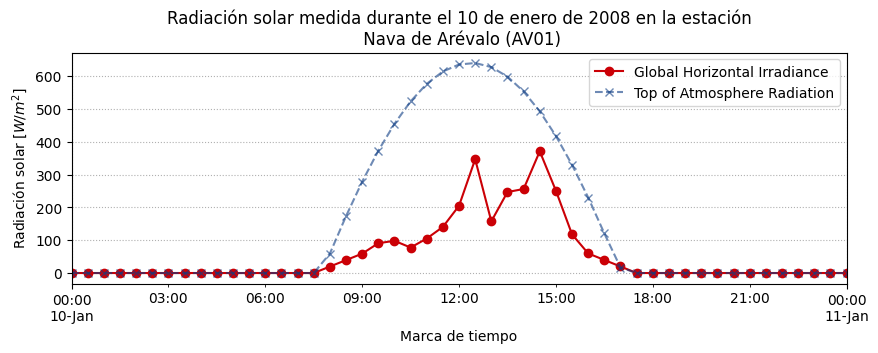

In [14]:
# Visualización de la radiación solar horizontal medida vs la radiación de la atmosfera superior para un día
example_station = "AV01"
fig, ax = plt.subplots(figsize=(10,3))
df_example[df_example.timestamp.between(f"{year}-01-10 00:00:00", f"{year}-01-11 00:00:00")].plot(x='timestamp', y='GHI', c='#CB0006', linestyle='-', marker='o', label='Global Horizontal Irradiance', ax=ax)
df_example[df_example.timestamp.between(f"{year}-01-10 00:00:00", f"{year}-01-11 00:00:00")].plot(x='timestamp', y='toa', c='#0E3D84', linestyle='--', marker='x', alpha=0.6, label='Top of Atmosphere Radiation', ax=ax)
ax.set_xlabel("Marca de tiempo")
ax.set_ylabel("Radiación solar $[W/m^{2}]$")
ax.set_title(f"Radiación solar medida durante el 10 de enero de {year} en la estación\n {df_geo[df_geo.station_code == example_station]['name'].iloc[0]} ({example_station})")
ax.grid(linestyle=':')
plt.show()

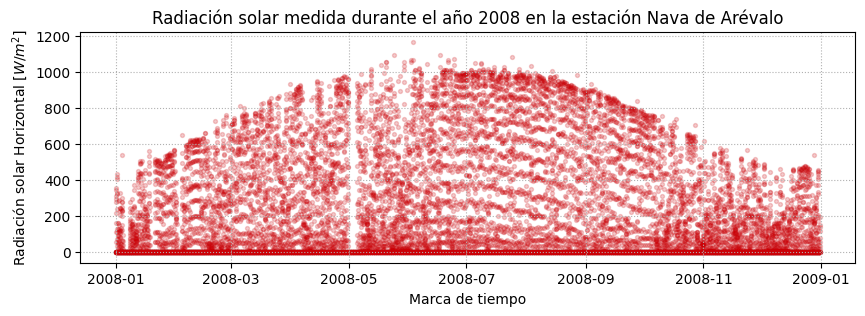

In [15]:
# Visualización de la radiación solar horizontal medida durante un año
fig, ax = plt.subplots(figsize=(10,3))
df_example.plot.scatter(x='timestamp', y='GHI', c='#CB0006', s=8, alpha=0.2, ax=ax)
ax.set_xlabel("Marca de tiempo")
ax.set_ylabel("Radiación solar Horizontal $[W/m^{2}]$")
ax.set_title(f"Radiación solar medida durante el año {year} en la estación {df_geo[df_geo.station_code == example_station]['name'].iloc[0]}")
ax.grid(linestyle=':')
plt.show()

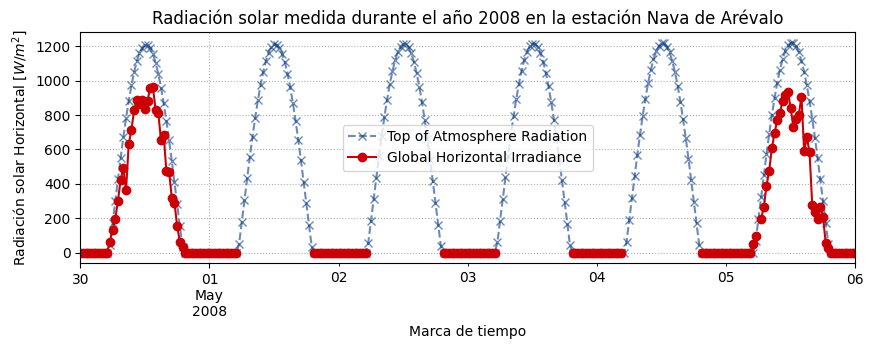

In [16]:
# Visualización de la radiación solar horizontal medida durante un año
fig, ax = plt.subplots(figsize=(10,3))
df_example[df_example.timestamp.between(f"{year}-04-30 00:00:00", f"{year}-05-06 00:00:00")].plot(x='timestamp', y='toa', c='#0E3D84', linestyle='--', marker='x', alpha=0.6, label='Top of Atmosphere Radiation', ax=ax)
df_example[df_example.timestamp.between(f"{year}-04-30 00:00:00", f"{year}-05-06 00:00:00")].plot(x='timestamp', y='GHI', c='#CB0006', linestyle='-', marker='o', label='Global Horizontal Irradiance', ax=ax)
ax.set_xlabel("Marca de tiempo")
ax.set_ylabel("Radiación solar Horizontal $[W/m^{2}]$")
ax.set_title(f"Radiación solar medida durante el año {year} en la estación {df_geo[df_geo.station_code == example_station]['name'].iloc[0]}")
ax.grid(linestyle=':')
plt.show()

El siguiente grafico generado muestra la radiación promedio medida a lo largo del dia para cada día del año, comparada con la radiación solar esperada a nivel de atmósfera superior.

In [18]:
# Generación de matriz de 
df_grouped = df_example.groupby([df_example['timestamp'].dt.date, df_example['timestamp'].dt.hour])[['GHI', 'toa']].mean().copy()
df_grouped.index.names = ['Date', 'Hour']
df_grouped.reset_index(inplace = True)
df_grouped['DayOfYear'] = pd.to_datetime(df_grouped['Date'], format='%Y-%m-%d').dt.strftime('%j').astype(int)
if calendar.isleap(int(year)):
    print(f"{year} es un año bisiesto")
    ghi = np.zeros((366, 24))
    toa = np.zeros((366, 24))
else:
    ghi = np.zeros((365, 24))
    toa = np.zeros((365, 24))

for _, row in df_grouped.iterrows():
    ghi[row['DayOfYear']-1][row['Hour']] = row['GHI']
    toa[row['DayOfYear']-1][row['Hour']] = row['toa']

2008 es un año bisiesto


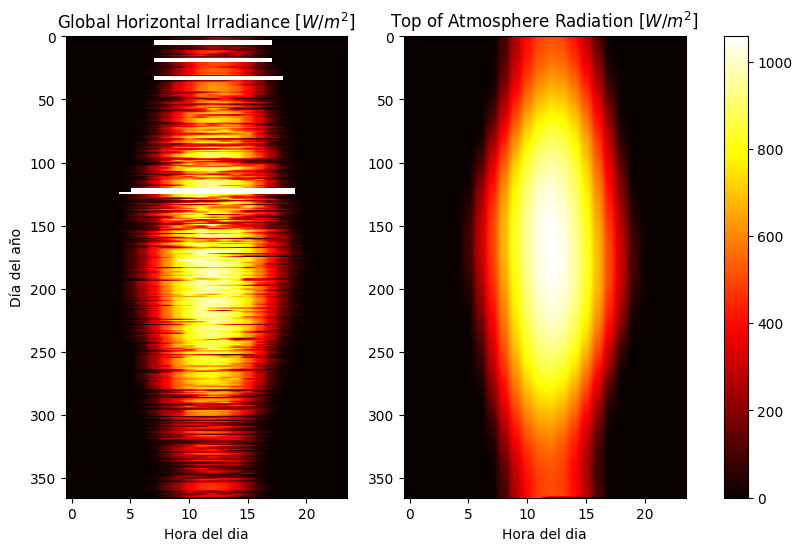

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))

# Gráfico de radiación solar medida
im = axs[0].imshow(ghi, aspect='auto', cmap='hot')
axs[0].set_xlabel('Hora del dia')
axs[0].set_ylabel('Día del año')
axs[0].set_title('Global Horizontal Irradiance $[W/m^{2}]$')
axs[0].grid(False)

# Gráfico de radiación solar teórica
im2 = axs[1].imshow(toa, aspect='auto', cmap='hot')
axs[1].set_xlabel('Hora del dia')
axs[1].set_title('Top of Atmosphere Radiation $[W/m^{2}]$')
axs[1].grid(False)

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

Con el fin de identificar relaciones entre las variables numericas existentes, se realizará un gráfico que permita identificar patrones entre estas. Para ello se hace uso de la función `seaborn.pairplot()` indicando además el listado de columnas con valores numéricos.

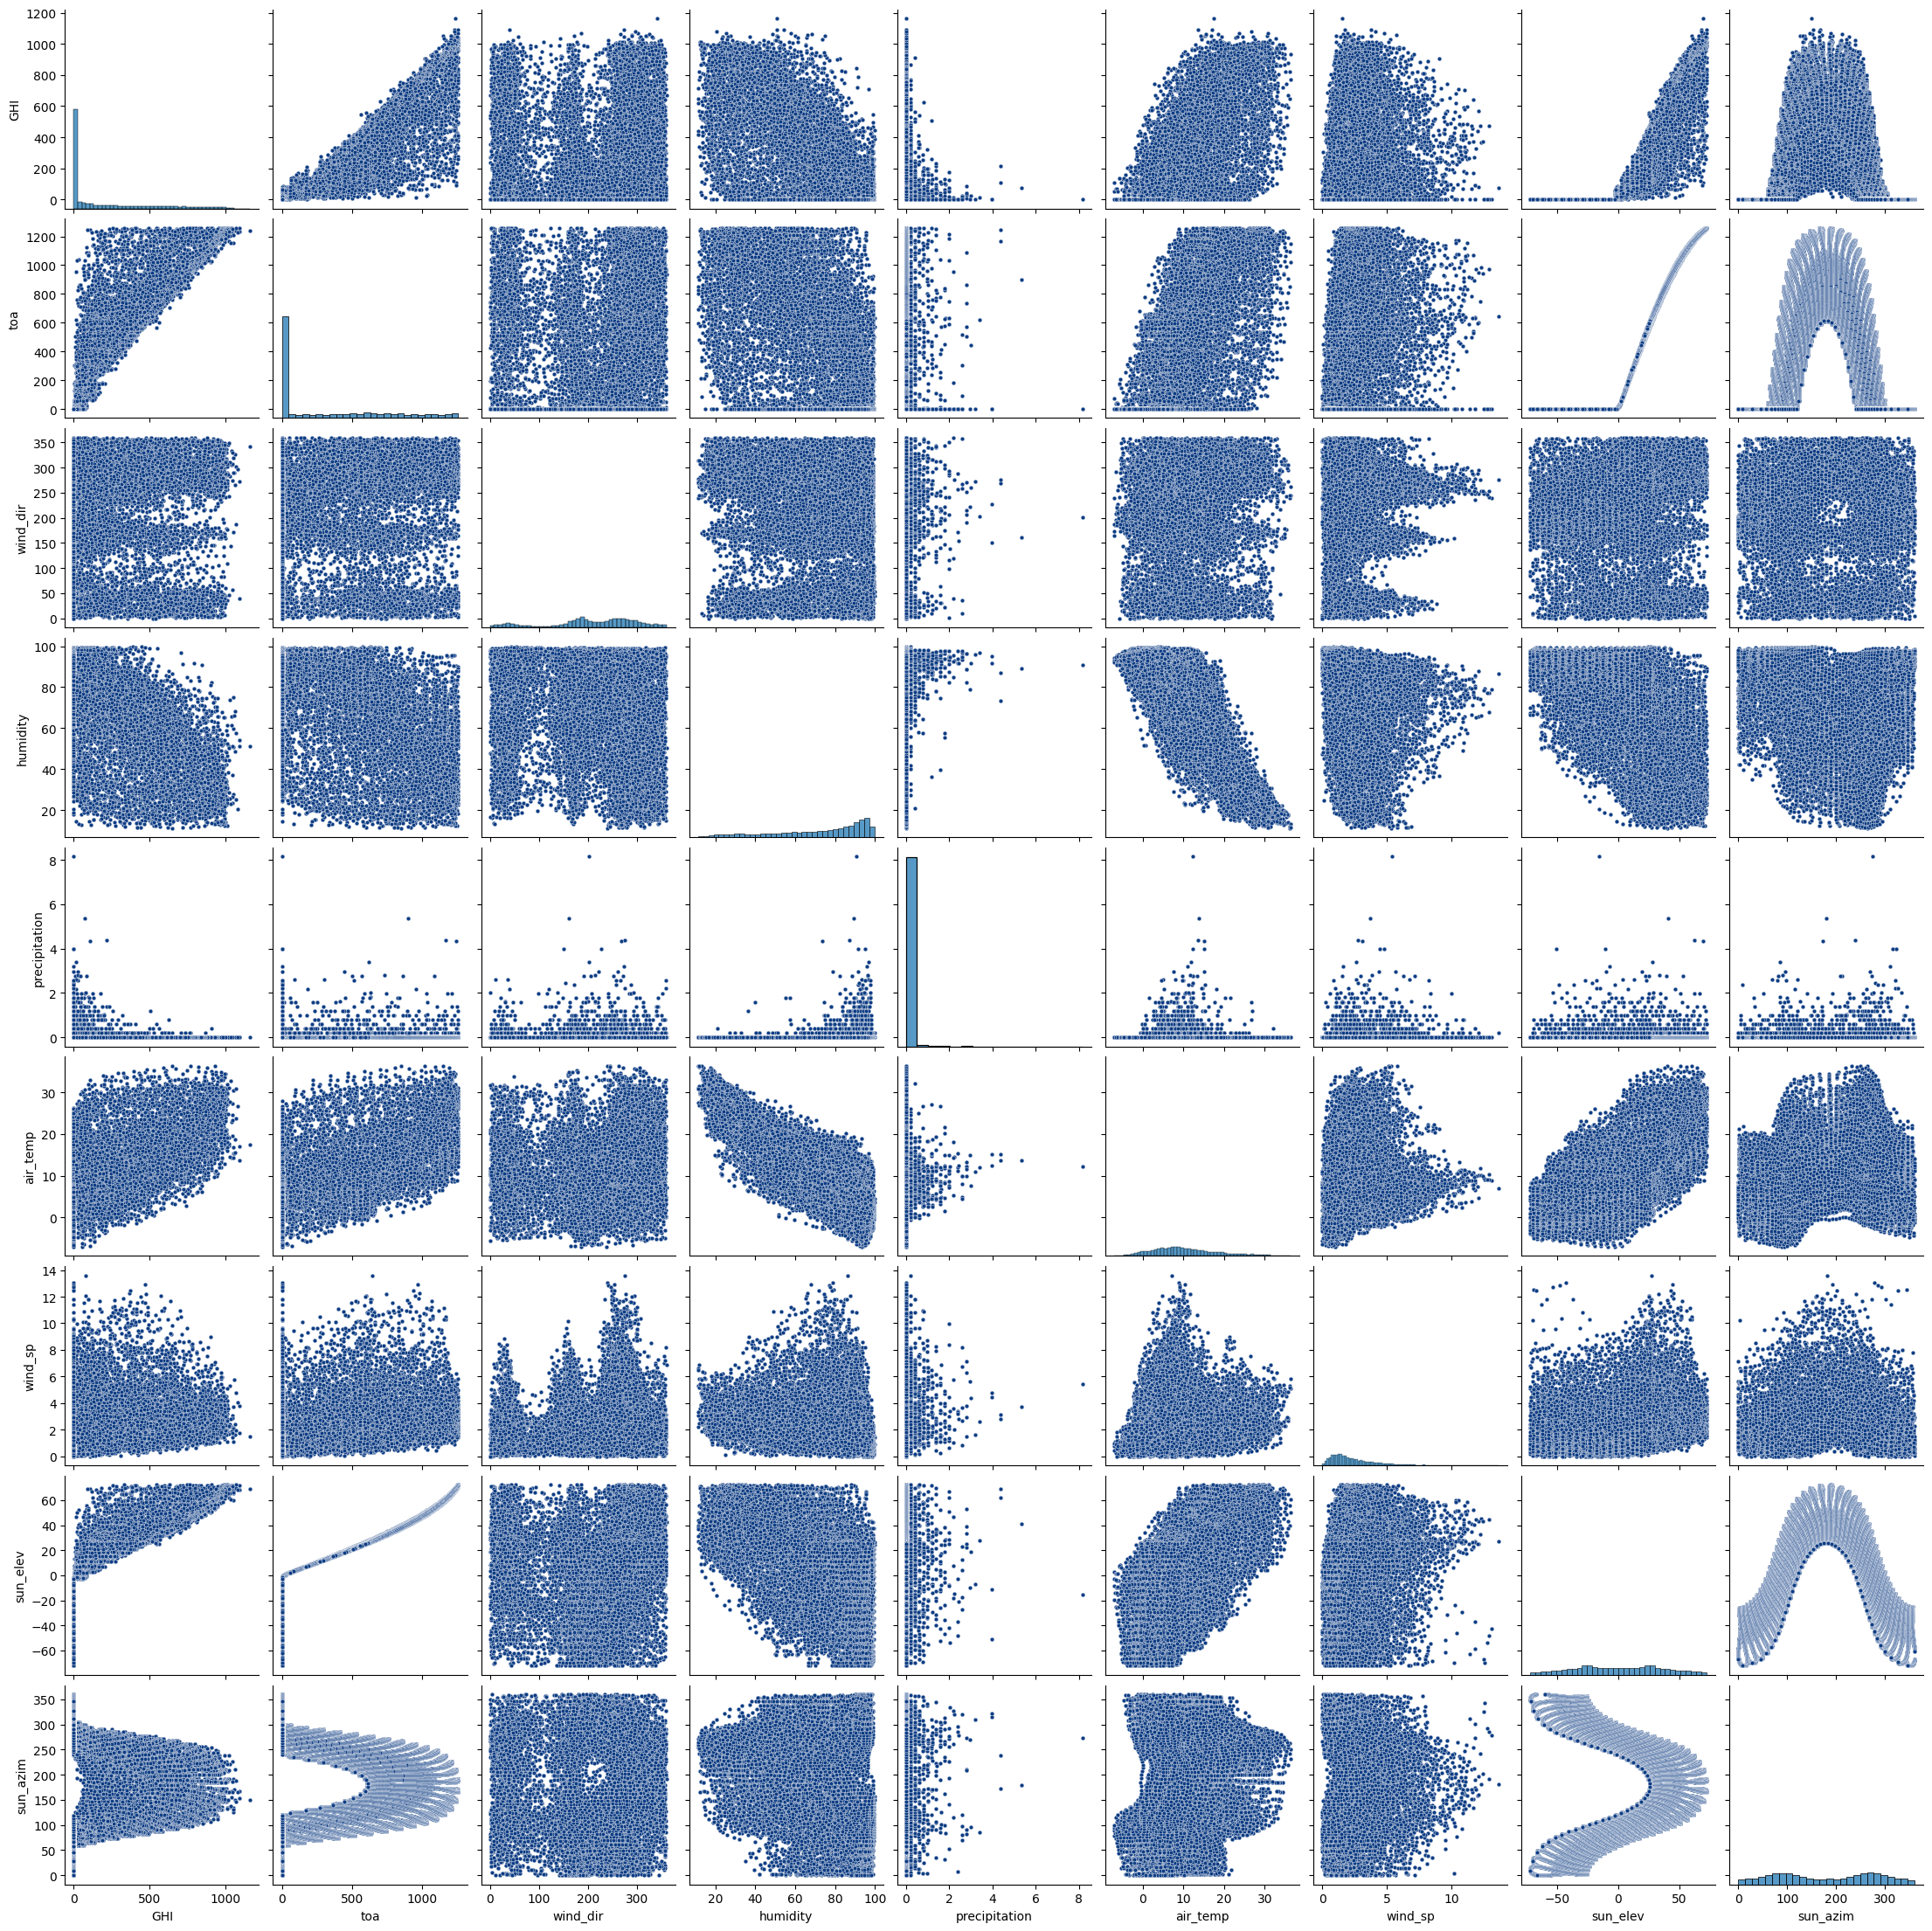

In [20]:
sns.pairplot(df_example, plot_kws={"s": 12, "c": '#0E3D84'})
plt.show()

#### Análisis de correlación

In [24]:
df_example = pd.read_csv(f"CasyLeon_by_stations/{example_station}.csv", sep=',', header=0)
df_example['timestamp'] = pd.to_datetime(df_example['timestamp'], format='%Y-%m-%d %H:%M:%S')

corr_matrix = df_example[[c for c in df_example if c != 'timestamp']].corr(method='pearson')
corr_matrix

GHI       toa  wind_dir  humidity  precipitation  \
GHI            1.000000  0.926718  0.035405 -0.644938      -0.056032   
toa            0.926718  1.000000  0.045295 -0.577225       0.003536   
wind_dir       0.035405  0.045295  1.000000 -0.048078       0.009448   
humidity      -0.644938 -0.577225 -0.048078  1.000000       0.084679   
precipitation -0.056032  0.003536  0.009448  0.084679       1.000000   
air_temp       0.583759  0.544207  0.100473 -0.828266      -0.021144   
wind_sp        0.204840  0.279848  0.159070 -0.177289       0.062954   
sun_elev       0.826551  0.900443  0.055352 -0.582177       0.005840   
sun_azim       0.002294  0.004161  0.012230 -0.281354       0.014971   

               air_temp   wind_sp  sun_elev  sun_azim  
GHI            0.583759  0.204840  0.826551  0.002294  
toa            0.544207  0.279848  0.900443  0.004161  
wind_dir       0.100473  0.159070  0.055352  0.012230  
humidity      -0.828266 -0.177289 -0.582177 -0.281354  
precipitation -0.021144  0.062954  0.005840  0.014971  
air_temp       1.000000  0.130490  0.565435  0.223794  
wind_sp        0.130490  1.000000  0.249729  0.110577  
sun_elev       0.565435  0.249729  1.000000  0.008497  
sun_azim       0.223794  0.110577  0.008497  1.000000

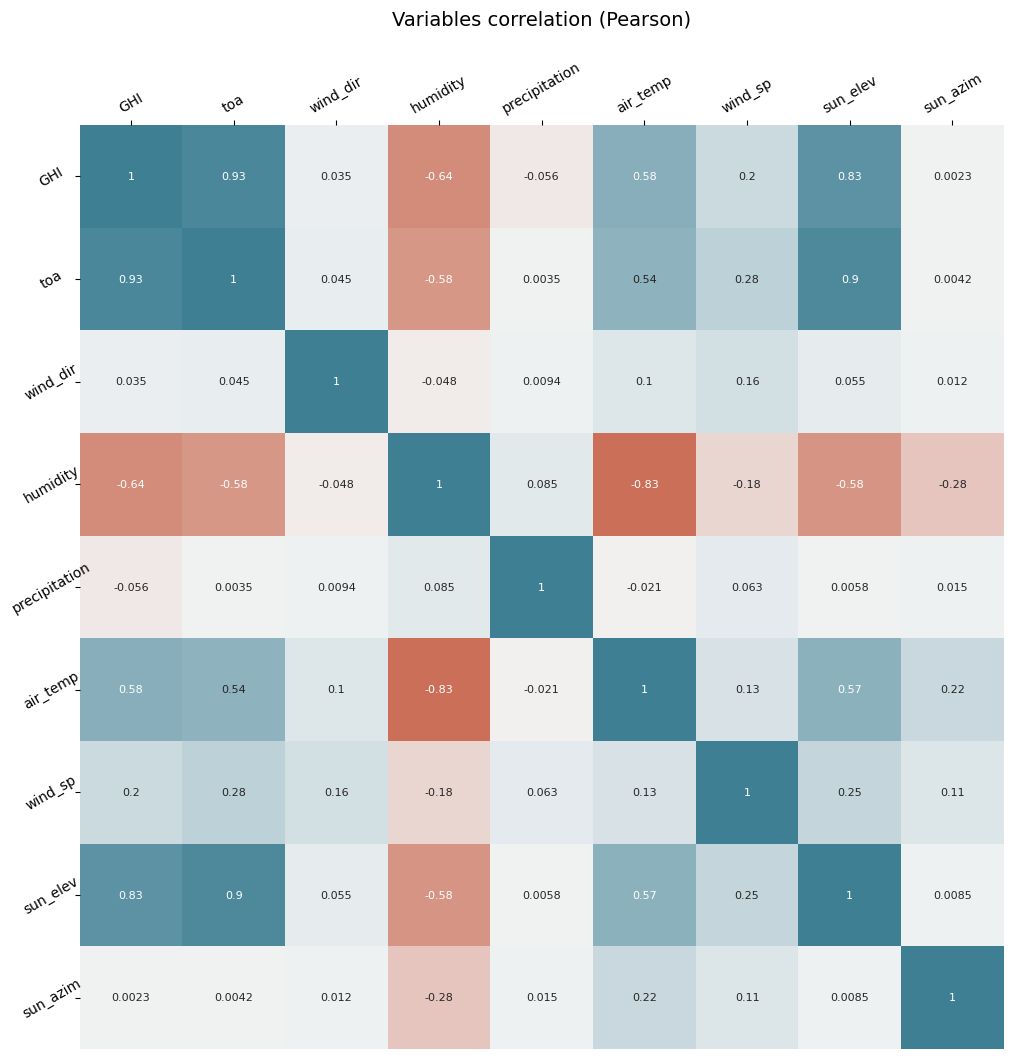

In [25]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    cbar=False,
    annot_kws={"size": 8},
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="center")
ax.set_yticklabels(ax.get_yticklabels(), rotation=30, ha="center", position=(-0.02, 0))

title = ax.set_title("Variables correlation (Pearson)", fontsize=14, y=1.1)

plt.show()

Al examinar la correlación lineal de Pearson entre cada variable, se destaca una correlación más notable entre el GHI y el TOA, así como entre ambos y el ángulo de elevación solar "sun_elev". Por otro lado, se observa una correlación negativa alta, cercana a -0.8, entre el porcentaje de humedad relativa y la temperatura del aire, así como correlaciones negativas, aunque no tan fuertes, entre el porcentaje de humedad relativa y la radiación solar, tanto GHI como TOA.